In [1]:
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch
from bisect import bisect
import torch.nn.functional as F
import numpy as np
from random import choice

from torch.utils.data import Dataset
from PIL import Image
# import cv2
import os
from glob import glob
from torchvision import transforms, datasets
from torch.utils.data.dataset import Dataset
import math
import torch.utils.data as data

import random
import logging
import time

from datetime import datetime
import torchvision

import torch.optim as optim

import matplotlib.pyplot as plt

from swin_functions import *
from codebook_functions import *
from adaptive_functions import *


save_directories = ["./recon/", "./Binary/Received_Text/", "./Binary/Received_Binary/", "./Binary/Transmitted_Binary/", "./Weights/", "./Datasets/"]

for save_dir in save_directories:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)


torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



class Args:
    def __init__(self):
        self.training = False  # Set to False if testing
        self.trainset = 'DIV2K'  # Choices: ['CIFAR10', 'DIV2K']
        self.testset = 'kodak'  # Choices: ['kodak', 'CLIC21', 'ffhq']
        self.distortion_metric = 'MSE'  # Choices: ['MSE', 'MS-SSIM']
        self.model = 'SwinJSCC_w/o_SAandRA'  # Choices: ['SwinJSCC_w/o_SAandRA', 'SwinJSCC_w/_SA', 'SwinJSCC_w/_RA', 'SwinJSCC_w/_SAandRA']
        self.channel_type = 'rayleigh'  # Choices: ['awgn', 'rayleigh']
        self.C = '32'  # Bottleneck dimension, any string/number value can be set (32 = 1/48, 64 = 1/24, 96 = 1/16, 128 = 1/12)
        self.multiple_snr = '3'  # Random or fixed SNR, set as string (e.g., '10')
        self.model_size = 'base'  # Choices: ['small', 'base', 'large']

# Initialize the arguments
args = Args()


class config():
    seed = 42
    pass_channel = True
    #CUDA = True
    #device = torch.device("cuda:0")
    CUDA = torch.cuda.is_available()  # Check if CUDA is available
    device = torch.device("cuda:0" if CUDA else "cpu")  # Use GPU if available, otherwise CPU
    norm = False
    # logger
    print_step = 100
    plot_step = 10000
    filename = datetime.now().__str__()[:-7]
    workdir = './history/{}'.format(filename)
    log = workdir + '/Log_{}.log'.format(filename)
    samples = workdir + '/samples'
    models = workdir + '/models'
    logger = None

    # training details
    normalize = False
    learning_rate = 0.0001
    tot_epoch = 10000000

    if args.trainset == 'CIFAR10':
        save_model_freq = 5
        image_dims = (3, 32, 32)
        train_data_dir = "/media/D/Dataset/CIFAR10/"
        test_data_dir = "/media/D/Dataset/CIFAR10/"
        batch_size = 128
        downsample = 2
        channel_number = int(args.C)
        encoder_kwargs = dict(
            img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
            embed_dims=[128, 256], depths=[2, 4], num_heads=[4, 8], C=channel_number,
            window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
            norm_layer=nn.LayerNorm, patch_norm=True,
        )
        decoder_kwargs = dict(
            img_size=(image_dims[1], image_dims[2]),
            embed_dims=[256, 128], depths=[4, 2], num_heads=[8, 4], C=channel_number,
            window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
            norm_layer=nn.LayerNorm, patch_norm=True,
        )
    elif args.trainset == 'DIV2K':
        save_model_freq = 100
        image_dims = (3, 256, 256)
        # train_data_dir = ["/media/D/Dataset/HR_Image_dataset/"]  
        base_path = "./Datasets/DIV2K"
        if args.testset == 'kodak':
            test_data_dir = ["./Datasets/Kodak"]
        elif args.testset == 'CLIC21':
            test_data_dir = ["/media/D/Dataset/HR_Image_dataset/clic2021/test/"]
        elif args.testset == 'ffhq':
            test_data_dir = ["/media/D/yangke/SwinJSCC/data/ffhq/"]

        train_data_dir = [base_path + '/DIV2K_train_HR/DIV2K_train_HR',
                          base_path + '/DIV2K_valid_HR/DIV2K_valid_HR']


        
        
        batch_size = 16
        downsample = 4
        if args.model == 'SwinJSCC_w/o_SAandRA' or args.model == 'SwinJSCC_w/_SA':
            channel_number = int(args.C)
        else:
            channel_number = None

        if args.model_size == 'small':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 2, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 2, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
        elif args.model_size == 'base':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 6, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 6, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
        elif args.model_size =='large':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 18, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 18, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )

def load_weights(model_path):
    pretrained = torch.load(model_path, map_location=device)
    net.load_state_dict(pretrained, strict=False)
    del pretrained
    
if args.trainset == 'CIFAR10':
    CalcuSSIM = MS_SSIM(window_size=3, data_range=1., levels=4, channel=3).to(device)
else:
    CalcuSSIM = MS_SSIM(data_range=1., levels=4, channel=3).to(device)


seed_torch()
logger = logger_configuration(config, save_log=False)
logger.info(config.__dict__)
torch.manual_seed(seed=config.seed)
net = SwinJSCC(args, config)
model_path = "./Weights/SwinJSCC_wo_SAandRA_Rayleigh_HRimage_snr3_psnr_C32.model"  
load_weights(model_path)
net = net.to(device)


2025-03-06 14:55:15,674 - INFO] {'__module__': '__main__', 'seed': 42, 'pass_channel': True, 'CUDA': False, 'device': device(type='cpu'), 'norm': False, 'print_step': 100, 'plot_step': 10000, 'filename': '2025-03-06 14:55:15', 'workdir': './history/2025-03-06 14:55:15', 'log': './history/2025-03-06 14:55:15/Log_2025-03-06 14:55:15.log', 'samples': './history/2025-03-06 14:55:15/samples', 'models': './history/2025-03-06 14:55:15/models', 'logger': <Logger Deep joint source channel coder (INFO)>, 'normalize': False, 'learning_rate': 0.0001, 'tot_epoch': 10000000, 'save_model_freq': 100, 'image_dims': (3, 256, 256), 'base_path': './Datasets/DIV2K', 'test_data_dir': ['./Datasets/Kodak'], 'train_data_dir': ['./Datasets/DIV2K/DIV2K_train_HR/DIV2K_train_HR', './Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR'], 'batch_size': 16, 'downsample': 4, 'channel_number': 32, 'encoder_kwargs': {'img_size': (256, 256), 'patch_size': 2, 'in_chans': 3, 'embed_dims': [128, 192, 256, 320], 'depths': [2, 2, 6,

Encoder  dim=3, input_resolution=(256, 256), depth=2
Encoder  dim=128, input_resolution=(128, 128), depth=2
Encoder  dim=192, input_resolution=(64, 64), depth=6
Encoder  dim=256, input_resolution=(32, 32), depth=2


2025-03-06 14:55:16,071 - INFO] Network config: 
2025-03-06 14:55:16,081 - INFO] Encoder: 
2025-03-06 14:55:16,082 - INFO] {'img_size': (256, 256), 'patch_size': 2, 'in_chans': 3, 'embed_dims': [128, 192, 256, 320], 'depths': [2, 2, 6, 2], 'num_heads': [4, 6, 8, 10], 'C': 32, 'window_size': 8, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'norm_layer': <class 'torch.nn.modules.normalization.LayerNorm'>, 'patch_norm': True}
2025-03-06 14:55:16,082 - INFO] Decoder: 
2025-03-06 14:55:16,084 - INFO] {'img_size': (256, 256), 'embed_dims': [320, 256, 192, 128], 'depths': [2, 6, 2, 2], 'num_heads': [10, 8, 6, 4], 'C': 32, 'window_size': 8, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'norm_layer': <class 'torch.nn.modules.normalization.LayerNorm'>, 'patch_norm': True}
2025-03-06 14:55:16,086 - INFO] 【Channel】: Built rayleigh channel, SNR 3 dB.


Decoder  dim=320, input_resolution=(16, 16), depth=2
Decoder  dim=256, input_resolution=(32, 32), depth=6
Decoder  dim=192, input_resolution=(64, 64), depth=2
Decoder  dim=128, input_resolution=(128, 128), depth=2


C:\Users\tharu\AppData\Local\Temp\ipykernel_7220\2462663927.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained = torch.load(model_path, map_location=device)


# **Transmitting Binary File**

**1) Without Codebook**

**Transmitter**

Number of adaptive patches created: 436
Final Grid Size: 768 x 640 (Multiple of 128)
Saved grid image to patches_grid.png
Saved patch info to patch_coords.bin


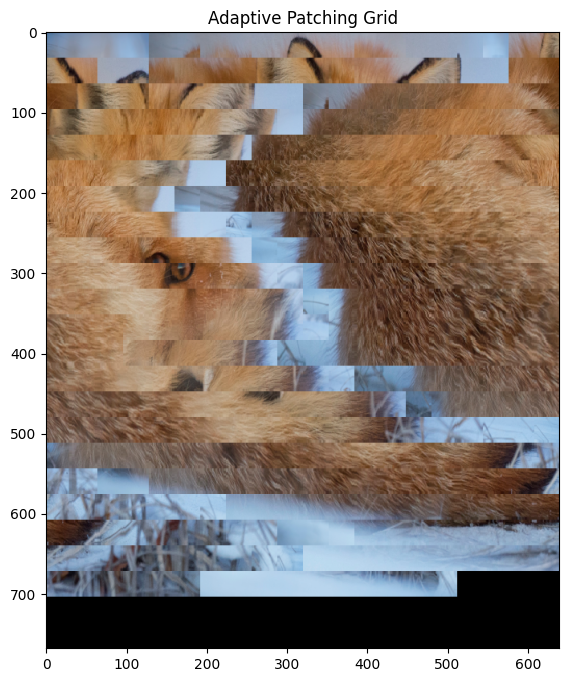

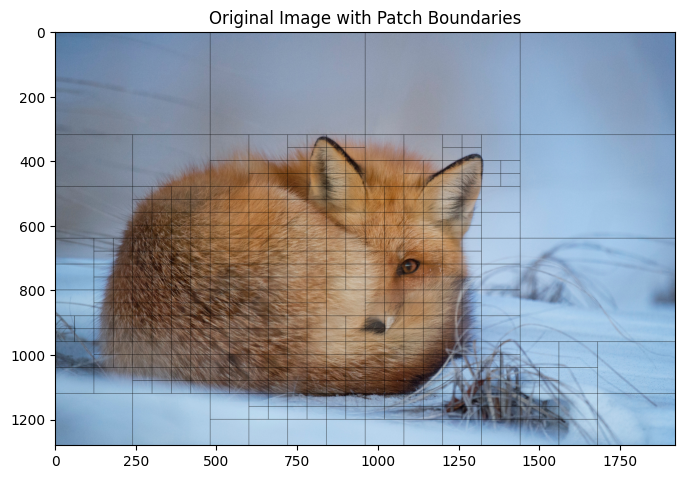

Original Resolution: 1280 x 1920
Image 'patches_grid.png' loaded successfully
tensor(0.7992)
tensor(-0.2379)
tensor(0.4069)
tensor(-1.1902)
Image encoded successfully
Encoded feature saved to './Binary/Transmitted_Binary/encoded_feature_img862.bin'


In [2]:
def process_and_encode_image_to_binary(image_path, output_path, NORMALIZE_CONSTANT=20, int_size=8):
    
    with torch.no_grad():
        config.isTrain = False
        net.eval()

        # Load the image
        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)
        print(f"Image '{image_name}' loaded successfully")

        # Encode the image
        feature, chan_snr, channel_rate = encode_image(input_image, net)
        print("Image encoded successfully")

        # Quantize and save as binary file
        feature_np = feature.cpu().numpy()  # Convert PyTorch tensor to NumPy array

        #quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 32767, -32767, 32767)).astype(np.int16)   #16 int
        #quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 127, -127, 127)).astype(np.int8)     #8 int

        if int_size == 8: quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 127, -127, 127)).astype(np.int8)
        elif int_size == 16: quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 32767, -32767, 32767)).astype(np.int16)
        
        quantized_feature.tofile(output_path)
        print(f"Encoded feature saved to '{output_path}'")

adaptive_patch_enabled = False

image_path = 'Datasets/Clic2021/01.png'
image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
#image_path = 'Datasets/Kodak/kodim23.png'

input_image, image_name= load_single_image(image_path, config)
resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
# Convert RGB to BGR for OpenCV compatibility
image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)

H_image, W_image = image.shape[:2]

H_new, W_new = encode_image_adaptive(image, kernel_size=1,
                                     tl=100, th=200,
                                     v=50,       # quadtree edge threshold
                                     H=5,        # maximum quadtree depth
                                     Pm=28,      # base patch size before padding
                                     L=None,     # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                                     grid_image_file="patches_grid.png", coord_file="patch_coords.bin",
                                     padding=2)

if (H_new * W_new) < (0.7 * H_image * W_image):
    adaptive_patch_enabled = True

print(f"Original Resolution: {H_image} x {W_image}")

tx_binary_base_path = './Binary/Transmitted_Binary/'

img_no = '862'

if adaptive_patch_enabled: image_path = 'patches_grid.png'

output_path= tx_binary_base_path +  f"encoded_feature_img{img_no}.bin"

process_and_encode_image_to_binary(image_path, output_path, NORMALIZE_CONSTANT=20, int_size=8)

**Receiver Side**

Image decoded successfully


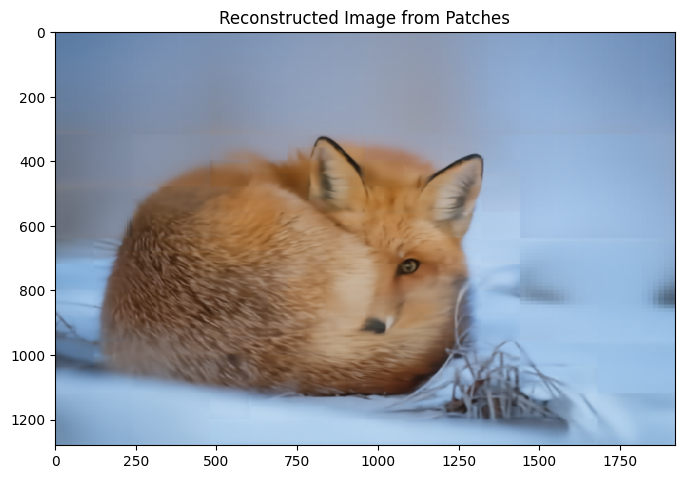

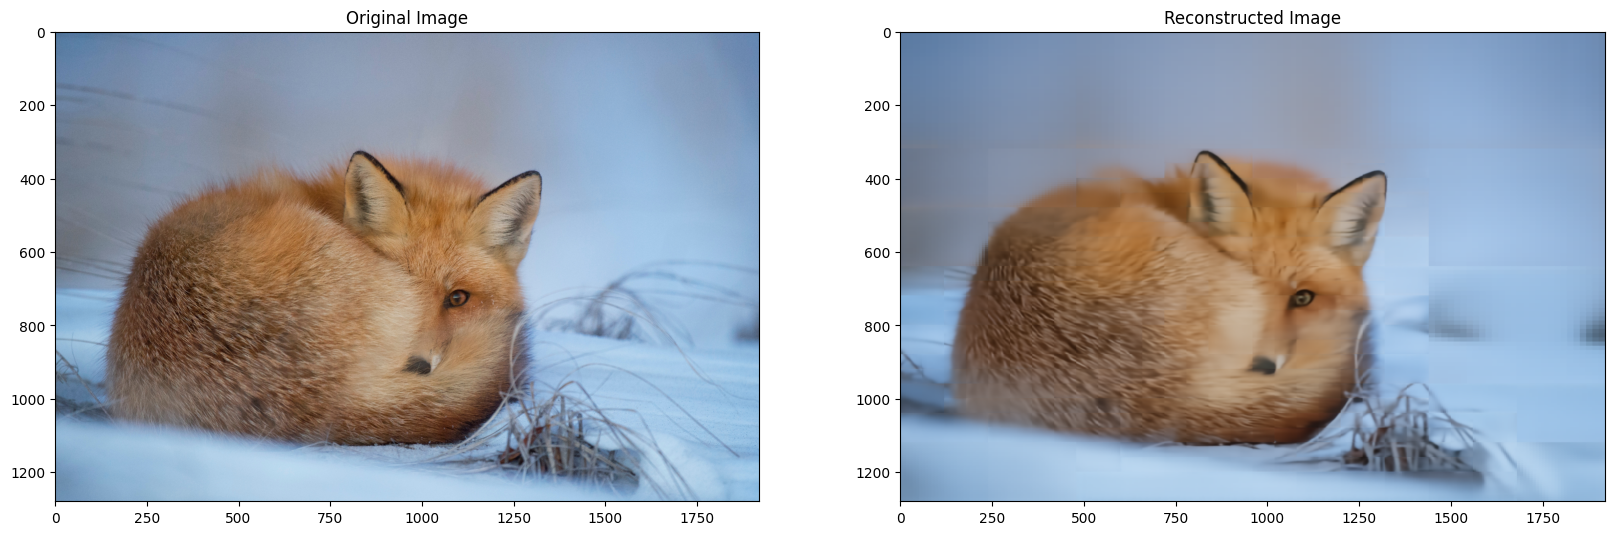

PSNR: 29.61 dB


In [3]:
def decode_and_evaluate(received_binary_path, image_path, resolution = (512,768), NORMALIZE_CONSTANT = 20, int_size=8, adaptive=False):           # Image path is original image

    tensor_shape = (1, int((resolution[0]*resolution[1])/(16*16)), 32)          # (Image size is 512x768x3 --> tensor (1, H/16 * W/16, 32))

    if int_size == 8: 
        received_feature = np.fromfile(received_binary_path, dtype=np.int8).reshape(tensor_shape)
        recovered_feature = received_feature / 127 * NORMALIZE_CONSTANT
    
    elif int_size == 16:
        received_feature = np.fromfile(received_binary_path, dtype=np.int16).reshape(tensor_shape)
        recovered_feature = received_feature / 32767 * NORMALIZE_CONSTANT


    recovered_feature_tensor = torch.from_numpy(recovered_feature).float().to(device)

    with torch.no_grad():
        
        net.eval()
        chan_snr = 10
        cbr_used = '1/48'

        recon_image = decode_image(recovered_feature_tensor, net, chan_snr, resolution)
        print("Image decoded successfully")

    input_image, image_name = load_single_image(image_path, config)   # To compare with the reconstructed
    input_image = input_image.to(device)

    recon_image = recon_image.clamp(0, 1)

    if adaptive == False:
        psnr_value = calculate_psnr(input_image, recon_image)

        plot_images(input_image, recon_image, image_name)

        print(f"PSNR: {round(psnr_value.item(), 3)} dB")
        print(f'CBR = {cbr_used}')

    else:
        save_image(recon_image, f"reconstructed_patches_grid.png")

        reconstructed_image = decode_image_adaptive(grid_image_file="./recon/reconstructed_patches_grid.png",
                                                    coord_file="patch_coords.bin",Pm=28, padding=2)
        reconstructed_image = reconstructed_image.clamp(0,1)
        
        psnr_value = calculate_psnr(input_image, reconstructed_image)

        plot_images(input_image, reconstructed_image, image_name)

        print(f"PSNR: {psnr_value:.2f} dB")


    #save_image(recon_image, f"reconstructed_{image_name}")


rx_binary_base_path = './Binary/Received_Binary/'

img_no = '862'                                                                    
image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'

received_bin_file = rx_binary_base_path + f'received_feature_img{img_no}.bin'

if adaptive_patch_enabled == False: 
    decode_and_evaluate(received_binary_path = received_bin_file , image_path = image_path, 
                        resolution = (1280,1920), NORMALIZE_CONSTANT=20, int_size=8, adaptive=False)
else:
    decode_and_evaluate(received_binary_path = received_bin_file , image_path = image_path , 
                        resolution = (768,640), NORMALIZE_CONSTANT=20, int_size=8, adaptive=True)


**2) With Codebook**

**Transmitter**

Number of adaptive patches created: 634
Final Grid Size: 896 x 768 (Multiple of 128)
Saved grid image to patches_grid.png
Saved patch info to patch_coords.bin


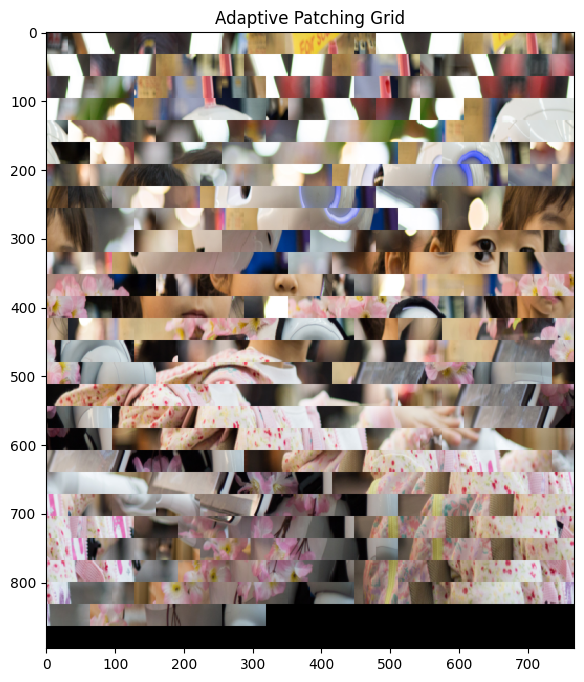

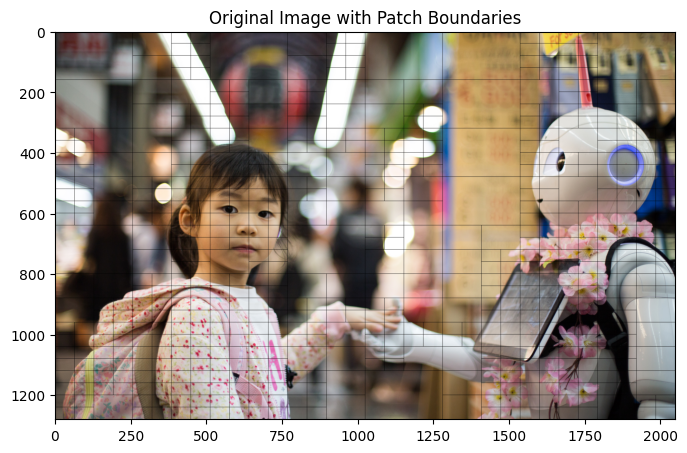

Original Resolution: 1280 x 2048
tensor(0.5839)
tensor(-0.2098)
tensor(0.3222)
tensor(-0.9207)
Encoded feature saved to ./Binary/Transmitted_Binary/indices_4d_512k_img06.bin


In [5]:
adaptive_patch_enabled = False

image_path = 'Datasets/Clic2021/01.png'
image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
image_path = "./Datasets/Clic2021/06.png"
#image_path = 'Datasets/Kodak/kodim23.png'

input_image, image_name= load_single_image(image_path, config)
resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
# Convert RGB to BGR for OpenCV compatibility
image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)

H_image, W_image = image.shape[:2]

H_new, W_new = encode_image_adaptive(image, kernel_size=1,
                                     tl=100, th=200,
                                     v=50,       # quadtree edge threshold
                                     H=5,        # maximum quadtree depth
                                     Pm=28,      # base patch size before padding
                                     L=None,     # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                                     grid_image_file="patches_grid.png", coord_file="patch_coords.bin",
                                     padding=2)

if (H_new * W_new) < (0.7 * H_image * W_image):
    adaptive_patch_enabled = True

print(f"Original Resolution: {H_image} x {W_image}")


codebook_path = './Codebook/codebook_4d_512clusters_mst.npy'
#codebook_path = './Codebook/codebook_4d_512clusters_rayleigh.npy'

chunk_size = 4         # 4d vectors in the codebook
k = 512

img_no = '06'


if adaptive_patch_enabled: test_image_path = 'patches_grid.png'

tx_binary_base_path = './Binary/Transmitted_Binary/'


indices, _ = encode_image_with_nd_codebook(net, codebook_path, test_image_path, config, device, chunk_size)
indices_np = indices.cpu().numpy()  # Convert PyTorch tensor to NumPy array

# Save indices to a binary file using a compact data type 
if k > 256: indices_np.astype(np.uint16).tofile( tx_binary_base_path + f"indices_{chunk_size}d_{k}k_img{img_no}.bin")  # Use uint16 as 512 fits in 16 bits
else :  indices_np.astype(np.uint8).tofile( tx_binary_base_path + f"indices_{chunk_size}d_{k}k_img{img_no}.bin")  # Use uint8 as 256 fits in 8 bits

print(f"Encoded feature saved to {tx_binary_base_path}indices_{chunk_size}d_{k}k_img{img_no}.bin")

**Receiver**

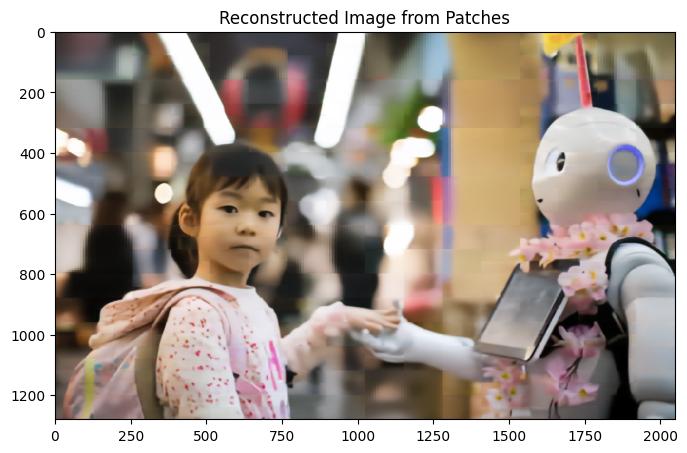

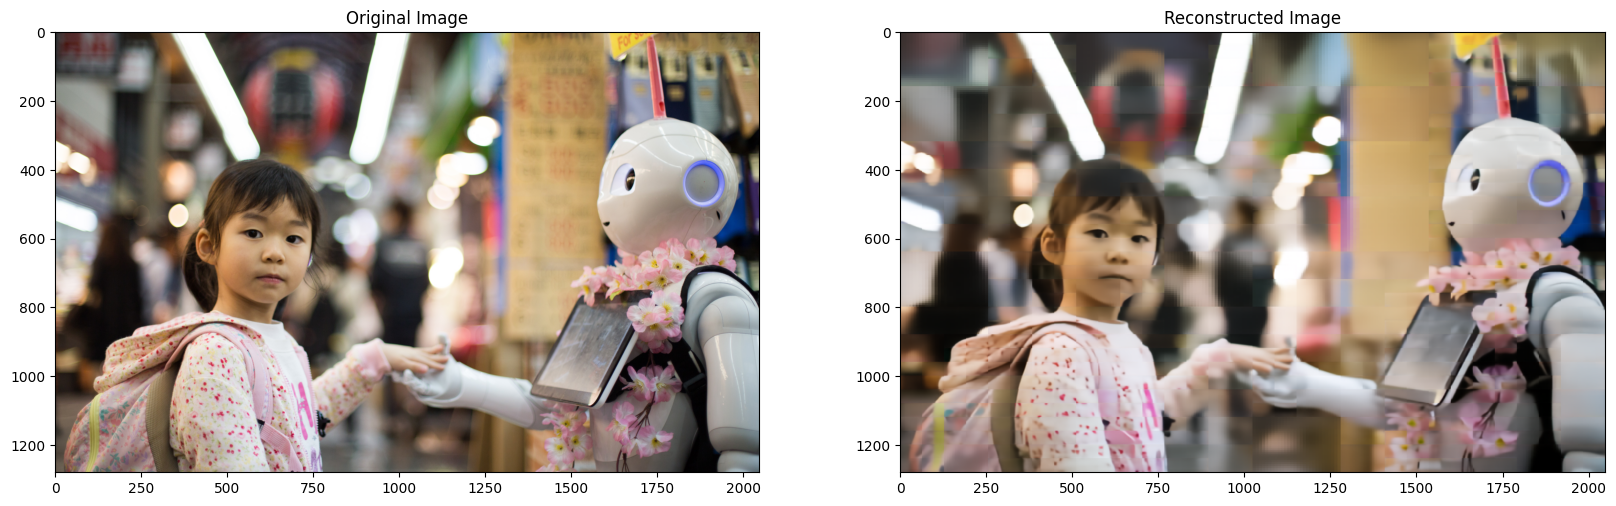

PSNR: 28.49 dB


In [6]:
def decode_indices_and_plot (received_binary_path , codebook_path, image_path ,chunk_size=4 ,resolution = (512,768), k=512, adaptive=False):

    if k > 256: loaded_indices = np.fromfile(received_binary_path, dtype=np.uint16)   # Use the same dtype as during saving
    else: loaded_indices = np.fromfile(received_binary_path, dtype=np.uint8)

    
    recovered_indices = torch.from_numpy(loaded_indices)   # Convert back to a PyTorch tensor
    recovered_indices = recovered_indices.int().to(device)  # Convert to int32 (Convert indices to a compatible type for clamping)

    # Calculate the number of bits needed based on k
    num_bits = int(np.ceil(np.log2(k)))  # Log base 2 of k gives the number of bits
    bitmask = (1 << num_bits) - 1       # Create a bitmask with 'num_bits' bits set to 1

    # Apply the bitmask to constrain the indices
    valid_indices = recovered_indices & bitmask    

    #valid_indices = torch.clamp(recovered_indices, min=0, max=511)  #  Clamp indices to the valid range  K=512
    valid_indices = torch.clamp(valid_indices, min=0, max=k-1)
    #valid_indices = recovered_indices

    M = int((resolution[0]*resolution[1])/(16*16))

    input_image, image_name = load_single_image(image_path, config)
    input_image = input_image.to(device)

    reconstructed = decode_image_with_nd_codebook(valid_indices, M, codebook_path, net, resolution, device, chunk_size)
    
    recon_image = reconstructed.clamp(0, 1)

    if adaptive == False:
        psnr_value = calculate_psnr(input_image, recon_image)
        plot_images(input_image, recon_image, image_name)
        print(f"PSNR: {round(psnr_value.item(), 3)} dB")
        print('CBR = 1/48')
        print(f'{chunk_size}d vectors in codebook')

    else:
        save_image(recon_image, f"reconstructed_patches_grid.png")
        reconstructed_image = decode_image_adaptive(grid_image_file="./recon/reconstructed_patches_grid.png",
                                                    coord_file="patch_coords.bin",Pm=28, padding=2)
        reconstructed_image = reconstructed_image.clamp(0,1)
        psnr_value = calculate_psnr(input_image, reconstructed_image)
        plot_images(input_image, reconstructed_image, image_name)
        print(f"PSNR: {psnr_value:.2f} dB")


        

    #save_image(recon_image, f"reconstructed_{image_name}")

rx_text_base_path =  './Binary/Received_Text/'
rx_binary_base_path = './Binary/Received_Binary/'


resolution = (512,768)
resolution = (896,768)

codebook_path = './Codebook/codebook_4d_512clusters_mst.npy'
chunk_size = 4
k= 512

img_no = '06'
image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
image_path = "./Datasets/Clic2021/06.png"

received_bin_file = rx_binary_base_path + f'received_indices_{chunk_size}d_{k}k_img{img_no}.bin'  


if adaptive_patch_enabled == False:
    decode_indices_and_plot(received_binary_path=received_bin_file , codebook_path=codebook_path ,image_path=image_path , chunk_size=chunk_size ,resolution=resolution, k=k, adaptive=False)
else:
    decode_indices_and_plot(received_binary_path=received_bin_file , codebook_path=codebook_path ,image_path=image_path , chunk_size=chunk_size ,resolution=resolution, k=k, adaptive=True)


# Simulation for 1 image

Image 'kodim23.png' loaded successfully
Number of adaptive patches created: 178
Final Grid Size: 512 x 384 (Multiple of 128)
Saved grid image to patches_grid.png
Saved patch info to patch_coords.bin


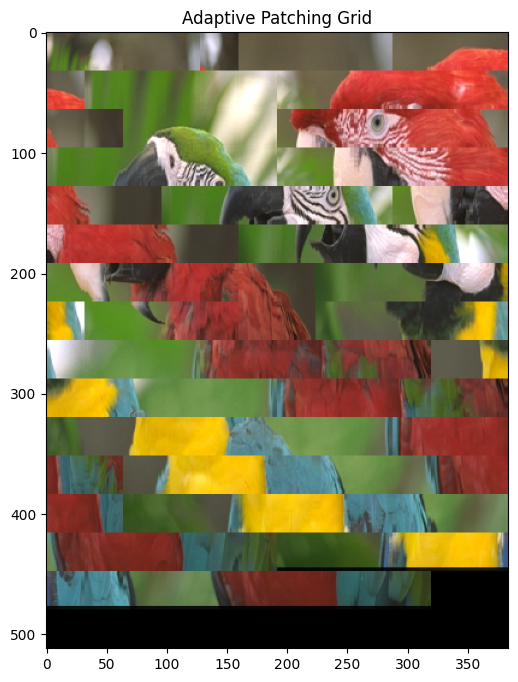

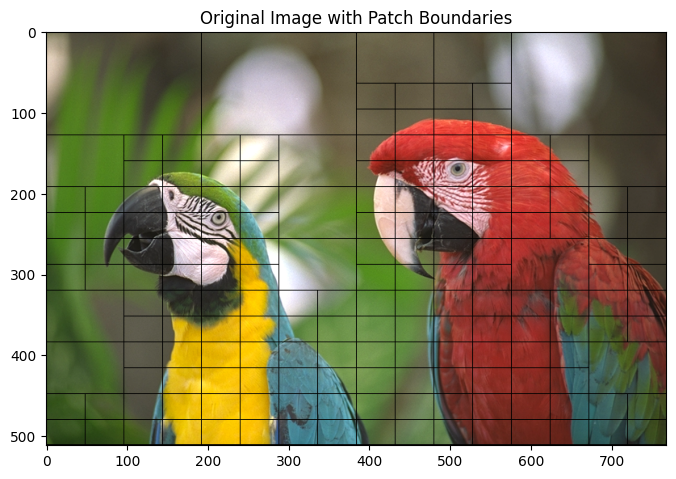

Original Resolution: 512 x 768
Adaptive Patch enabled : True
Image 'patches_grid.png' loaded successfully
tensor(1.0118)
tensor(-0.3907)
tensor(0.8907)
tensor(-1.2423)
Image encoded successfully
Feature passed through channel
Image decoded successfully


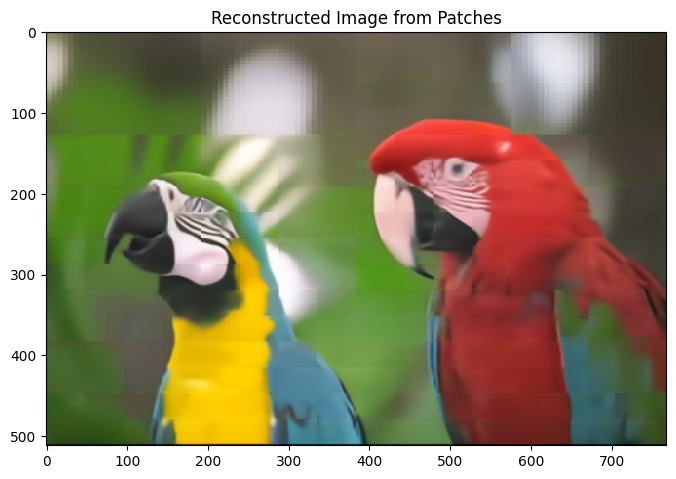

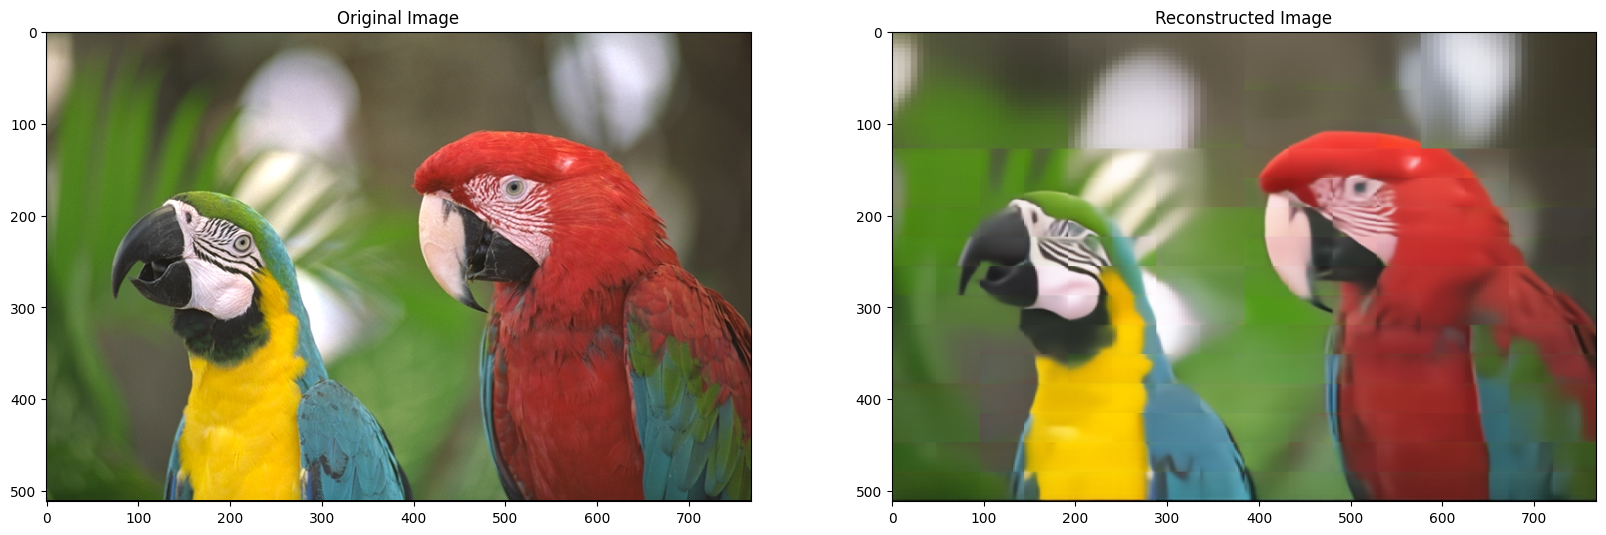

PSNR: 27.67 dB


In [7]:
adaptive_patch_enabled = False

#image_path = 'Datasets/Clic2021/01.png'
# image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
# image_path = "./Datasets/Clic2021/06.png"
image_path = 'Datasets/Kodak/kodim23.png'
#image_path = 'Datasets/Kodak/kodim25.jpeg'

original_image, original_image_name = load_single_image(image_path, config)
original_image = original_image.to(device)
print(f"Image '{original_image_name}' loaded successfully")

resized_image_np = original_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
# Convert RGB to BGR for OpenCV compatibility
image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)

H_image, W_image = image.shape[:2]

H_new, W_new = encode_image_adaptive(image, kernel_size=1,tl=100, th=200,
                                     v=50,       # quadtree edge threshold
                                     H=5,        # maximum quadtree depth
                                     Pm=28,      # base patch size before padding
                                     L=None,     # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                                     grid_image_file="patches_grid.png", coord_file="patch_coords.bin",
                                     padding=2)

if (H_new * W_new) < (0.7 * H_image * W_image):
    adaptive_patch_enabled = True

print(f"Original Resolution: {H_image} x {W_image}")
print(f'Adaptive Patch enabled : {adaptive_patch_enabled}')


# Encoder

with torch.no_grad():
    
    config.isTrain = False
    net.eval()

    if adaptive_patch_enabled : 
        encode_path = 'patches_grid.png'
        input_image, image_name= load_single_image(encode_path, config)
        input_image = input_image.to(device)
        print(f"Image '{image_name}' loaded successfully")
    else : 
        input_image = original_image


    # Step 2: Encode the image
    feature, chan_snr, channel_rate = encode_image(input_image, net)
    print("Image encoded successfully")

#Channel

noisy_feature = pass_through_channel(feature, net, chan_snr)       # Change SNR here if needed
print("Feature passed through channel")
noisy_feature = feature  # If channel is not simulated

#Decoder

resolution = input_image.shape[2], input_image.shape[3]

with torch.no_grad():
    recon_image = decode_image(noisy_feature, net, chan_snr, resolution)
    print("Image decoded successfully")


cbr_used = "1/"+ str(int((32*48)/channel_rate))
channel_used = "Rayleigh" if args.channel_type == 'rayleigh' else "AWGN" 

recon_image = recon_image.clamp(0, 1)

if adaptive_patch_enabled:
    save_image(recon_image, f"reconstructed_patches_grid.png")

    reconstructed_image = decode_image_adaptive(grid_image_file="./recon/reconstructed_patches_grid.png",
                                                coord_file="patch_coords.bin",Pm=28, padding=2)
    reconstructed_image = reconstructed_image.clamp(0,1)
    psnr_value = calculate_psnr(original_image, reconstructed_image)
    plot_images(original_image, reconstructed_image, original_image_name)
    print(f"PSNR: {psnr_value:.2f} dB")

else:

    psnr_value = calculate_psnr(original_image, recon_image)
    plot_images(original_image, recon_image, original_image_name)
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f'{channel_used} Channel, SNR = {chan_snr} dB')
    print(f'CBR = {cbr_used}')


# Codebook Simulation for 1 image

Image 'kodim25.jpeg' loaded successfully
Number of adaptive patches created: 130
Final Grid Size: 384 x 384 (Multiple of 128)
Saved grid image to patches_grid.png
Saved patch info to patch_coords.bin


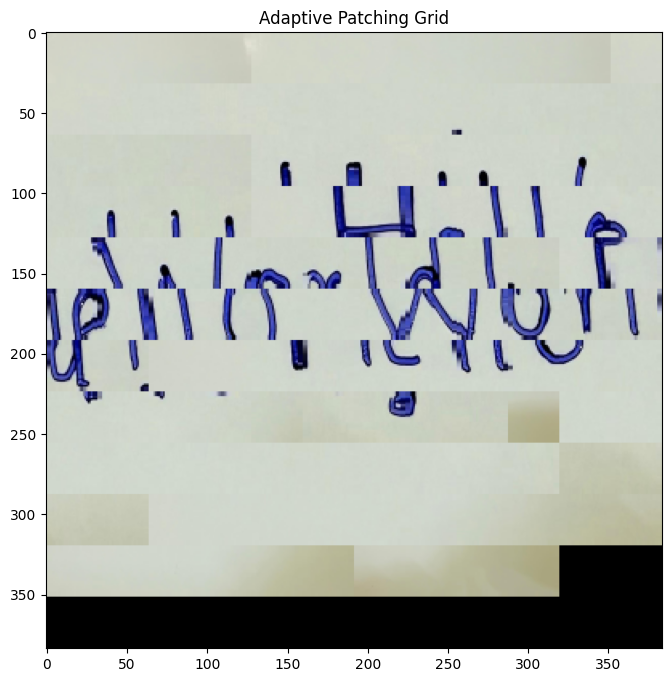

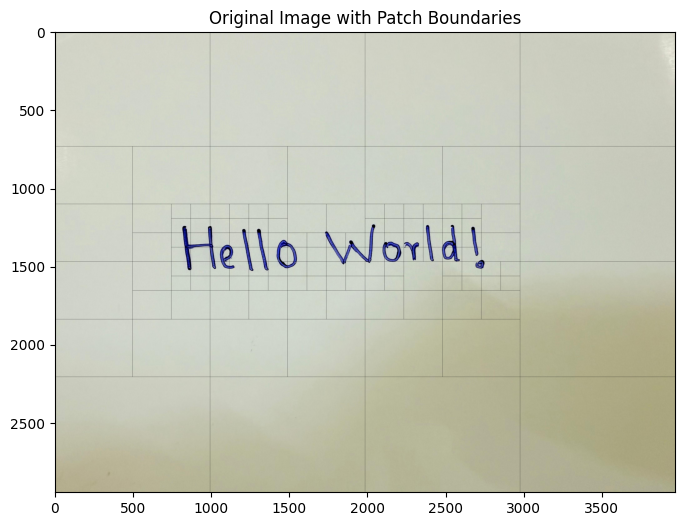

Original Resolution: 2944 x 3968
Adaptive Patch enabled : True
tensor(0.0481)
tensor(0.1707)
tensor(0.2274)
tensor(-0.8144)


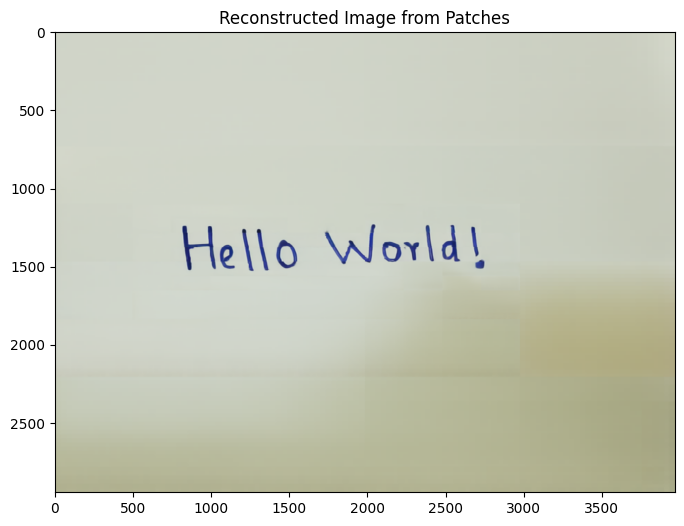

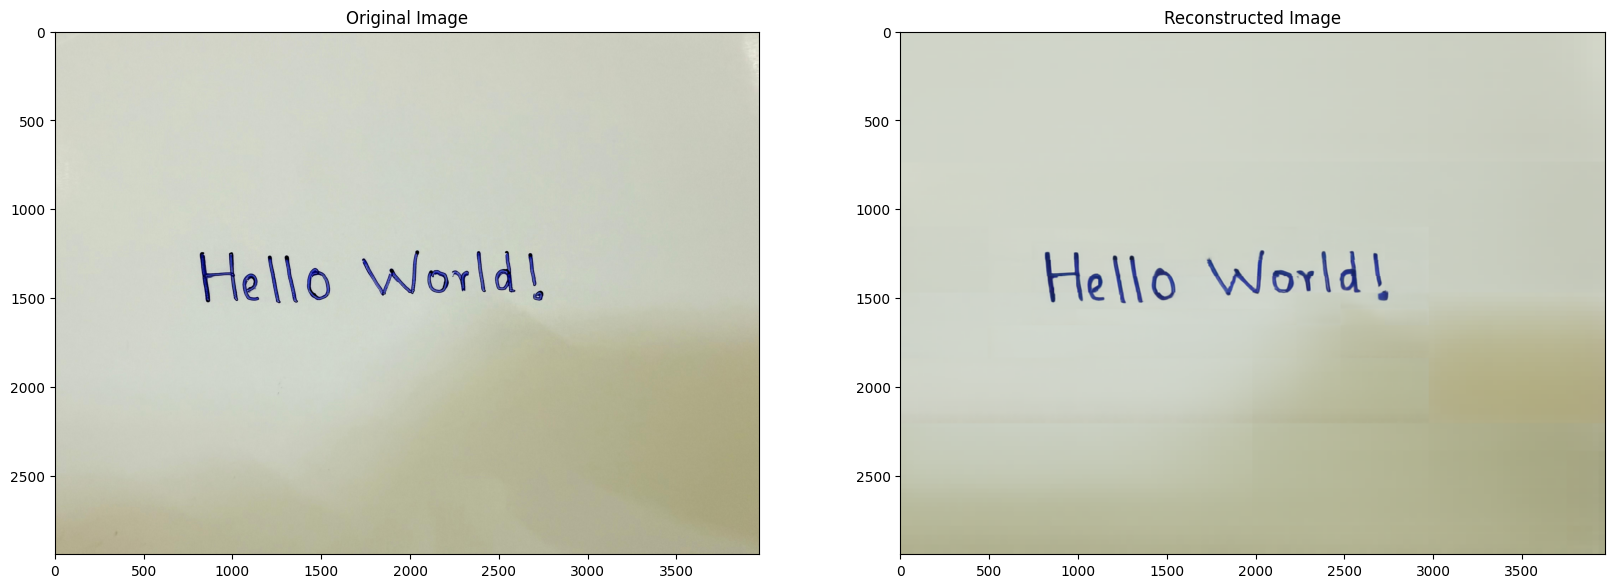

PSNR: 32.52 dB


In [8]:
adaptive_patch_enabled = False

image_path = 'Datasets/Clic2021/01.png'
image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
image_path = "./Datasets/Clic2021/06.png"
# image_path = 'Datasets/Kodak/kodim23.png'
image_path = 'Datasets/Kodak/kodim25.jpeg'

original_image, original_image_name = load_single_image(image_path, config)
original_image = original_image.to(device)
print(f"Image '{original_image_name}' loaded successfully")

resized_image_np = original_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
# Convert RGB to BGR for OpenCV compatibility
image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)

H_image, W_image = image.shape[:2]

H_new, W_new = encode_image_adaptive(image, kernel_size=1,tl=100, th=200,
                                     v=50,       # quadtree edge threshold
                                     H=5,        # maximum quadtree depth
                                     Pm=28,      # base patch size before padding
                                     L=None,     # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                                     grid_image_file="patches_grid.png", coord_file="patch_coords.bin",
                                     padding=2)

if (H_new * W_new) < (0.7 * H_image * W_image):
    adaptive_patch_enabled = True

print(f"Original Resolution: {H_image} x {W_image}")
print(f'Adaptive Patch enabled : {adaptive_patch_enabled}')


from bitarray import bitarray

#adaptive_patch_enabled = False

codebook_path = './Codebook/codebook_4d_512clusters_mst.npy'
chunk_size = 4
k=512

if adaptive_patch_enabled: 
    image_path = 'patches_grid.png'
    input_image, image_name = load_single_image(image_path, config)
    input_image = input_image.to(device)
else : 
    input_image = original_image

indices, M = encode_image_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size)
indices_np = indices.cpu().numpy()  # Convert PyTorch tensor to NumPy array

# Save indices to a binary file using a compact data type 
if k > 256: indices_np.astype(np.uint16).tofile( './Binary/test.bin')  # Use uint16 as 512 fits in 16 bits
else :  indices_np.astype(np.uint8).tofile( './Binary/test.bin')  # Use uint8 as 256 fits in 8 bits


#Add Noise Here If needed
def introduce_channel_noise(binary_file, output_file, noise_type="AWGN", snr_db=10):
    """
    Introduce channel noise (AWGN or Rayleigh) in a binary file.
    
    Args:
        binary_file (str): Path to the original binary file.
        output_file (str): Path to save the noisy binary file.
        noise_type (str): Type of noise to apply ("AWGN" or "Rayleigh").
        snr_db (float): Signal-to-noise ratio in decibels.
    """
    # Load the original binary data
    bit_stream = bitarray()
    with open(binary_file, 'rb') as f:
        bit_stream.fromfile(f)
    
    # Convert bit stream to array of 0s and 1s
    bit_array = np.array(bit_stream.tolist(), dtype=np.float32)
    
    # Map bits to BPSK symbols (-1 for 0, +1 for 1)
    bpsk_symbols = 2 * bit_array - 1
    
    # Calculate noise power from SNR
    snr_linear = 10 ** (snr_db / 10)
    signal_power = np.mean(np.abs(bpsk_symbols) ** 2)
    noise_power = signal_power / snr_linear
    
    # Apply noise based on the selected type
    if noise_type == "AWGN":
        # Add Gaussian noise
        noise = np.sqrt(noise_power / 2) * np.random.randn(len(bpsk_symbols))
        received_signal = bpsk_symbols + noise
    elif noise_type == "Rayleigh":
        # Apply Rayleigh fading
        rayleigh_fading = np.sqrt(np.random.exponential(scale=2, size=len(bpsk_symbols)))
        noise = np.sqrt(noise_power / 2) * np.random.randn(len(bpsk_symbols))
        received_signal = rayleigh_fading * bpsk_symbols + noise
    else:
        raise ValueError("Unsupported noise type. Choose 'AWGN' or 'Rayleigh'.")
    
    # Demodulate to recover bits (hard decision decoding)
    demodulated_bits = (received_signal >= 0).astype(np.uint8)
    
    # Save the noisy bit stream to a new file
    noisy_bit_stream = bitarray(demodulated_bits.tolist())
    with open(output_file, 'wb') as f:
        noisy_bit_stream.tofile(f)
    
    print(f"Noisy binary file saved to '{output_file}' with {noise_type} noise at {snr_db} dB SNR.")

#introduce_channel_noise('./Binary/test.bin', './Binary/test.bin', noise_type="AWGN", snr_db=1)

if k > 256: loaded_indices = np.fromfile('./Binary/test.bin', dtype=np.uint16)   # Use the same dtype as during saving
else: loaded_indices = np.fromfile('./Binary/test.bin', dtype=np.uint8)

recovered_indices = torch.from_numpy(loaded_indices)   # Convert back to a PyTorch tensor
recovered_indices = recovered_indices.int().to(device)  # Convert to int32 (Convert indices to a compatible type for clamping)

# Calculate the number of bits needed based on k
num_bits = int(np.ceil(np.log2(k)))  # Log base 2 of k gives the number of bits
bitmask = (1 << num_bits) - 1       # Create a bitmask with 'num_bits' bits set to 1
valid_indices = recovered_indices & bitmask
valid_indices = torch.clamp(valid_indices, min=0, max=k-1)



res = (input_image.shape[2], input_image.shape[3])
reconstructed = decode_image_with_nd_codebook(valid_indices, M, codebook_path, net, res, device, chunk_size)
recon_image = reconstructed.clamp(0, 1)

if adaptive_patch_enabled == False:
    psnr_value = calculate_psnr(original_image, recon_image)
    plot_images(original_image, recon_image, image_name)
    print(f"PSNR: {round(psnr_value.item(), 3)} dB")
    print(f'{chunk_size}d vectors in codebook')

else:
    save_image(recon_image, f"reconstructed_patches_grid.png")
    reconstructed_image = decode_image_adaptive(grid_image_file="./recon/reconstructed_patches_grid.png",
                                                coord_file="patch_coords.bin",Pm=28, padding=2)
    reconstructed_image = reconstructed_image.clamp(0,1)
    psnr_value = calculate_psnr(original_image, reconstructed_image)
    plot_images(original_image, reconstructed_image, image_name)
    print(f"PSNR: {psnr_value:.2f} dB")